# Baseball Data Retrieval and Processing

### In this notebook, we will be focusing on the **acquisition**, **preprocessing**, and **exploratory data analysis** of both baseball payroll and performance data. Some of the work that will be done in this notebook will also be used in later steps when observing correlations between economic data and baseball payroll. 

### The main **objectives** are to:

#### 1. Collect baseball data surrounding both team performance and payroll from several different sources
#### 2. Prepare and clean this data for analysis
#### 3. Analyze the correlations between payroll and performance for baseball teams
---

### Part 1: Acquiring and Processing Payroll Data

**Data Sources**
<br>Our primary source is stathead.com which will contain our pitching and hitting performance data for all teams between 1998 and 2023. We will then combine this with our payroll data pulled from baseballprospectus.com. BaseballProspectus has some gaps in their payroll data, specifically for the years 1998, 1999, 2021, 2022, and 2023. To account for these gaps, we will pull data from stevetheump.com.

First we'll import the neccessary libraries that will help us fetch and manipulate the data. We will use bs4 to scrape the web data, and then we will use pandas to manipulate the dataframes created from this scraped data. Regex will be used to specify which specific strings we are looking to export or manipulate.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

#### SteveTheUmp's Payroll Data 
First we will scrape the entire html content from **stevetheump**'s website which will contain our missing payroll data for years 1998, 1999, 2021, 2022, and 2023.

The data for years 2021, 2022, and 2023 are located in "tables" within the html structure of the url. However, the data for years 1998 and 1999 are not, so we will pull these two years separately at a later step.

In [2]:
# Specify which url we want to scrape from
url = "https://www.stevetheump.com/Payrolls.htm"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# Find all table tags/markers
tables = soup.find_all("table")

# This list will hold our dataframes
processed_dfs = []

# Because our data on the website is sorted in descending order by year, we will use these tuples to help us scrape
tables_and_years = [(1, 2023), (2, 2022), (3, 2021)]

# Loop through each tuple in tables_and_years
for table_index, year in tables_and_years:
    # Read the HTML table
    df = pd.read_html(str(tables[table_index]), header=0)[0]

    # Adjust column names based on how they appear ('Total Payroll' for 2023, 'Total' for other years)
    if year == 2023:
        df = df[["Team", "Total Payroll"]]
        df.rename(columns={"Total Payroll": "Payroll"}, inplace=True)
    else:
        df = df[["Team", "Total"]]
        df.rename(columns={"Total": "Payroll"}, inplace=True)

    df["Year"] = year
    processed_dfs.append(df)

# Concatenate and sort the columns of all of the processed DataFrames
df = pd.concat(processed_dfs, ignore_index=True)[["Year", "Team", "Payroll"]]


# Let's look at a sample from this dataframe to validate
df.sample(5)

,Year,Team,Payroll
32,2022,New York Mets,"$253,119,999"
54,2022,Arizona Diamondbacks,"$75,993,333"
52,2022,Cincinnati Reds,"$99,580,000"
3,2023,Philadelphia Phillies,"$232,424,939"
51,2022,Minnesota Twins,"$110,859,524"


Now we will pull the data for 1998 and 1999. For this data, we will have to look for unique markers in the html code to identify the data because it is not formatted in "tables" like for the above years. The process for extracting these two years differs in the HTML elements targeted, the regex patterns used, and the method for processing the data. For example, for 1999, data is extracted from 'span' elements, while 1998 data follows 'pre' elements, using a regex pattern that allows for optional whitespace. 

In [3]:
# Lists to store the extracted data
years = []
teams = []
payrolls = []

# Find the marker for the 1999 section and then process its data
# Specifically we are looking for the anchor tag name "team payrolls"
marker_1999 = soup.find("a", {"name": "team payrolls"})
# Look for a span tag with a class style2
for span in marker_1999.find_all_next("span", {"class": "style2"}, limit=1):
    lines = span.decode_contents().split("<br/>")
    for line in lines:
        line = line.strip()
        if not line:
            continue
        # Match team name and payroll format
        match = re.search(r"([A-Za-z. ]+): \$?([\d,]+)", line)
        if match:
            teams.append(match.group(1).strip())
            payrolls.append(match.group(2).replace(",", ""))
            years.append("1999")

# Find the marker for the 1998 section and process its data
marker_1998 = soup.find("a", {"name": "98_payroll"})
for pre in marker_1998.find_all_next("pre", limit=2):
    lines = pre.get_text(separator="\n").split("\n")
    for line in lines:
        line = line.strip()
        if not line:
            continue
        match = re.search(r"([A-Za-z. ]+?):\s*\$?([\d,]+)", line)
        if match:
            teams.append(match.group(1).strip())
            payrolls.append(match.group(2).replace(",", ""))
            years.append("1998")

# Creating a DataFrame
df1 = pd.DataFrame({"Year": years, "Team": teams, "Payroll": payrolls})

# Let's take a look at a sample form this dataframe
df1.sample(10)

,Year,Team,Payroll
12,1999,Anaheim,49868167
35,1998,Cleveland,59543165
8,1999,Arizona,70496000
47,1998,Chicago White Sox,35180000
39,1998,Chicago Cubs,49816000
42,1998,Houston,48304000
13,1999,Toronto,48455333
15,1999,San Francisco,45959557
55,1998,Cincinnati,20707333
51,1998,Philadelphia,28622500


#### Baseball Prospectus Payroll Data
Now we can proceed with our "easier" dataset from **Baseball Prospectus** which needs minimal exception handling. We have a standardized method for each year which we can loop through to capture all data.

In [4]:
# Create an empty DataFrame to store all data
all_years_data = pd.DataFrame()

# Loop through years from 2000 to 2020
for year in range(2000, 2021):
    url = f"https://legacy.baseballprospectus.com/compensation/?cyear={year}&team=&pos="
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the table by ID or class (adjust as needed)
    table = soup.find("table", {"id": "cotsyear_datagrid"})

    # Check if table exists for the year
    if table:
        # Extract table rows
        rows = table.find_all("tr")

        # Extract headings if all_years_data is empty
        if all_years_data.empty:
            headings = [th.get_text() for th in rows[0].find_all("th")]

        # Extract data
        data = []
        for row in rows[1:]:
            rowData = [td.get_text() for td in row.find_all("td")]
            data.append(rowData)

        # Create DataFrame for the year
        year_df = pd.DataFrame(data, columns=headings)

        # Add a new column for the year
        year_df["Year"] = year  # Adding a column with the current year

        # Append the data of the year to the main DataFrame
        all_years_data = pd.concat([all_years_data, year_df], ignore_index=True)
    else:
        print(f"Data for year {year} not found.")

# All_years_data now contains data from 2000 to 2020
rn = all_years_data.rename(columns={"Team Name": "Team"})
df2 = rn[["Team", "Year", "Payroll"]]

# Let's take a look at a sample from this dataframe
df2.sample(5)

,Team,Year,Payroll
216,TOTAL,2006,"$2,371,552,638"
453,Oakland Athletics,2014,"$82,445,900"
9,Detroit Tigers,2000,"$60,225,167"
555,Toronto Blue Jays,2017,"$163,381,937"
41,Florida Marlins,2001,"$34,376,500"


### Great! Now let's combine all of our payroll data 

In [5]:
# Let's combine the three dataframes into one payroll dataframe
combined = pd.concat([df, df1, df2], ignore_index=True)

# Remove the dollar sign from payroll for easier manipulation later on
combined["Payroll"] = (
    combined["Payroll"].replace({"\$": "", ",": ""}, regex=True).astype(int)
)

# Set all the types
combined["Year"] = combined["Year"].astype(int)
combined["Team"] = combined["Team"].astype(str)
combined["Payroll"] = combined["Payroll"].astype(int)

# Remove the aggregate columns that came in the dataset
combined = combined[
    ~combined["Team"].str.contains("total|average", case=False, na=False)
]

# Sort by year ascending and payroll descending
sorted_df = combined.sort_values(
    by=["Year", "Payroll"], ascending=[True, False]
).reset_index(drop=True)

# Look at a sample from this sorted dataframe
sorted_df.sample(5)

,Year,Team,Payroll
247,2006,Chicago Cubs,93257833
257,2006,Texas Rangers,68894360
142,2002,Cincinnati Reds,43203890
423,2012,Los Angeles Angels,155023024
110,2001,Cincinnati Reds,47974000


This looks good. Now let's check to see if there are any teams who have had name changes or location changes. I know that Cleveland changed their name and Montreal and Los Angeles have had changes in their team's locations. Let's check these three.

In [6]:
sorted_df[
    sorted_df["Team"].str.contains("Cleveland|Expo|Angel", case=False)
].drop_duplicates(subset=["Team"])[["Team"]]

,Team
2,Los Angeles
5,Cleveland
61,Los Angeles Dodgers
67,Cleveland Indians
78,Los Angeles Angels
83,Montreal Expos
690,Los Angeles Dodgers
693,Los Angeles Angels
717,Cleveland Indians
746,Cleveland Guardians


Interesting, there seems to be different labels based on the year. Let's create a dictionary with maps of keywords to team names and abbreviations which we can later use to classify and join on.

In [7]:
def rewrite_cell_and_abbr(cell):
    # Maps of keywords to team names and abbreviations
    teams = {
        "arizona": ("Arizona Diamondbacks", "ARI"),
        "atlanta": ("Atlanta Braves", "ATL"),
        "baltimore": ("Baltimore Orioles", "BAL"),
        "boston": ("Boston Red Sox", "BOS"),
        "cubs": ("Chicago Cubs", "CHC"),
        "white sox": ("Chicago White Sox", "CHW"),
        "cincinnati": ("Cincinnati Reds", "CIN"),
        "cleveland": ("Cleveland Guardians", "CLE"),
        "colorado": ("Colorado Rockies", "COL"),
        "detroit": ("Detroit Tigers", "DET"),
        "florida": ("Miami Marlins", "MIA"),
        "miami": ("Miami Marlins", "MIA"),
        "milwaukee": ("Milwaukee Brewers", "MIL"),
        "minnesota": ("Minnesota Twins", "MIN"),
        "montreal": ("Washington Nationals", "WSN"),
        "expos": ("Washington Nationals", "WSN"),
        "mets": ("New York Mets", "NYM"),
        "yankees": ("New York Yankees", "NYY"),
        "oakland": ("Oakland Athletics", "OAK"),
        "philadelphia": ("Philadelphia Phillies", "PHI"),
        "pittsburgh": ("Pittsburgh Pirates", "PIT"),
        "diego": ("San Diego Padres", "SDP"),
        "francisco": ("San Francisco Giants", "SFG"),
        "seattle": ("Seattle Mariners", "SEA"),
        "louis": ("St. Louis Cardinals", "STL"),
        "tampa": ("Tampa Bay Rays", "TBR"),
        "texas": ("Texas Rangers", "TEX"),
        "toronto": ("Toronto Blue Jays", "TOR"),
        "washington": ("Washington Nationals", "WSN"),
        "houston": ("Houston Astros", "HOU"),
        "kansas": ("Kansas City Royals", "KCR"),
        "angels": ("Los Angeles Angels", "LAA"),
        "anaheim": ("Los Angeles Angels", "LAA"),
        "dodgers": ("Los Angeles Dodgers", "LAD"),
        "los angeles": ("Los Angeles Dodgers", "LAD"),
    }

    # Let's lowercase everything for easier mapping
    cell_lower = cell.lower()
    for keyword, (name, abbr) in teams.items():
        if keyword in cell_lower:
            return name, abbr

    return cell, cell


# Apply the function to the DataFrame and assign results to two new columns
sorted_df["Team Name"], sorted_df["Team_ABR"] = zip(
    *sorted_df["Team"].apply(rewrite_cell_and_abbr)
)
sorted_df.rename(columns={"Year": "Season"}, inplace=True)

# Let's look at some expected problem rows to see what they look like now. 
#the 'Team' column is our old data and the 'Team Name' column is our updated version of the column
sorted_df[
    sorted_df["Team"].str.contains("Indians|Expo|Anaheim|Devil|Florida", case=False)
].drop_duplicates(subset=["Team"]).head(5)

,Season,Team,Payroll,Team Name,Team_ABR
11,1998,Anaheim,48389000,Los Angeles Angels,LAA
27,1998,Florida,15141000,Miami Marlins,MIA
67,2000,Cleveland Indians,76938090,Cleveland Guardians,CLE
83,2000,Montreal Expos,32285666,Washington Nationals,WSN
88,2000,Florida Marlins,19008000,Miami Marlins,MIA


Great! Now, let's ingest our performance data. 

### Performance Data from Stathead
This data needed to be pulled in 8 separate csv files because of a 200 row limit. We will import these files into dataframes and then combine these dataframes into one which shows both hitting and pitching stats. These excel files contain not only individual outcome stats like Home Runs, Singles, Doubles, and Strikeouts but also high level performance stats like Earned Run Average, Walks and Hits Per Inning Pitched, Batting Average, On Base Percentage, and more. 

In [8]:
# Read the exports from stahead
sp1 = pd.read_excel("data/sp1.xlsx")
sp2 = pd.read_excel("data/sp2.xlsx")
sp3 = pd.read_excel("data/sp3.xlsx")
sp4 = pd.read_excel("data/sp4.xlsx")
sp5 = pd.read_excel("data/sp5.xlsx")
sp6 = pd.read_excel("data/sp6.xlsx")
sp7 = pd.read_excel("data/sp7.xlsx")
sp8 = pd.read_excel("data/sp8.xlsx")

# create pitching and hitting dataframes
hitting = pd.concat([sp1, sp2, sp3, sp4], ignore_index=True)
pitching = pd.concat([sp5, sp6, sp7, sp8], ignore_index=True)

# Joining the hitting and pitching data, setting suffixes for our duplicate stats which have different implications
# i.e. Strikeouts are a stat measured in both, negative attribute for hitting but positive for pitching
merged_df = pd.merge(
    hitting,
    pitching,
    how="outer",
    on=["Season", "Team"],
    suffixes=("_HITTING", "_PITCHING"),
)


# Replace old abbreviations with new ones which we will use to join with payroll data
def rewrite_abbr(cell):
    if "mon" in cell.lower():
        return "WSN"
    elif "ana" in cell.lower():
        return "LAA"
    elif "fla" in cell.lower():
        return "MIA"
    elif "tbd" in cell.lower():
        return "TBR"
    return cell


# Apply this function to a specific column
merged_df["Team"] = merged_df["Team"].apply(rewrite_abbr)

# Look at a sample from this dataframe
merged_df.sample(5)

,Rk_HITTING,Season,Team,Lg_HITTING,GP_HITTING,W_HITTING,L_HITTING,WL%_HITTING,Bat#,PA,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/BB
228,229,2016,NYY,AL,162,84,78,0.519,42,6059,...,52,6023,104,4.20,1.262,8.6,1.3,2.8,8.8,3.14
747,748,1999,TEX,AL,162,95,67,0.586,32,6389,...,50,6313,100,4.60,1.486,10.2,1.2,3.2,6.1,1.92
278,279,2014,CLE,AL,162,85,77,0.525,43,6222,...,56,6193,110,3.42,1.268,8.6,0.8,2.8,8.9,3.13
577,578,2004,CIN,NL,162,76,86,0.469,44,6278,...,74,6451,82,5.10,1.501,9.9,1.5,3.6,6.2,1.73
586,587,2004,MIN,AL,162,92,70,0.568,36,6286,...,45,6269,117,3.98,1.324,9.3,1.0,2.6,6.8,2.61


---
### Part 2: Joining Our Payroll and Performance Dataframes
Now we can join our two dataframes! We first will make sure that we fix any specific issues in the data, and that we will use an outer join to join the dataframes so that if there are any flawed keys that we try to join on, we can easily diagnose them by looking for null elements

In [9]:
# Let's get rid of our 'Team' column as we have created it's updated version in 'Team Name'
# Let's also rename the column 'Team_ABR' so that we can join it with our payroll data
sorted_df.drop("Team", axis=1, inplace=True)
sorted_df.rename(columns={"Team_ABR": "Team"}, inplace=True)

# Combine payroll with performance data on season and team, we use outer join so that it is easier to trouble shoot (look for nulls)
final_df = pd.merge(merged_df, sorted_df, how="outer", on=["Season", "Team"])

# in our raw data source (SteveTheUmp's website) there was an additional zero in the Yankees' payroll in 1999
final_df.loc[
    (final_df["Season"] == 1999) & (final_df["Team"] == "NYY"), "Payroll"
] = 88180712

# let's take a look at this final dataframe
final_df.sample(5)

,Rk_HITTING,Season,Team,Lg_HITTING,GP_HITTING,W_HITTING,L_HITTING,WL%_HITTING,Bat#,PA,...,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/BB,Payroll,Team Name
187,188,2017,CIN,NL,162,68,94,0.420,47,6213,...,87,5.08,1.450,9.1,1.6,4.0,8.2,2.06,95375786,Cincinnati Reds
252,253,2015,HOU,AL,162,86,76,0.531,39,6073,...,110,3.66,1.201,8.2,0.9,2.6,8.0,3.03,72464200,Houston Astros
646,647,2002,MIN,AL,161,94,67,0.584,34,6196,...,109,4.20,1.310,9.1,1.1,2.7,6.4,2.34,39950000,Minnesota Twins
106,107,2020,MIN,AL,60,36,24,0.600,20,2168,...,122,3.79,1.204,7.9,1.1,3.0,9.4,3.15,131799311,Minnesota Twins
400,401,2010,DET,AL,162,81,81,0.500,37,6312,...,98,4.15,1.372,9.0,0.9,3.3,6.6,1.97,134062066,Detroit Tigers


---
### Part 3: Preparing Our Dataframe for Analysis
There are a few things that we must add to our dataframe so that we can seamlessly conduct analysis downstream.

We will be:
<br><span style="margin-left: 20px;">**adjusting teams' payrolls for inflation**, 
<br><span style="margin-left: 20px;">**"z-score normalizing" our adjusted payrolls so that we can reduce variability across seasons and focus our analysis on relative payroll position during a given season**,
<br><span style="margin-left: 20px;">**allocating rankings to teams based on their large market vs small market categorizations**


#### Adjusting Payrolls
In this step, we will pull CPI data from FRED, group it by year and calculate the mean value for All Urban Consumers.
We will then Calculate the Adjusted Payroll for each year in "2023 dollars".

In [10]:
# Retrieve and Aggregate CPI data
cpi_df = pd.read_csv("data/CPI.csv")
cpi_df["DATE"] = pd.to_datetime(cpi_df["DATE"])
cpi_df["YEAR"] = cpi_df["DATE"].dt.year
yearly_cpi = cpi_df.groupby("YEAR")["CPIAUCSL"].mean().reset_index()

# Creating a new dataframe with our CPI values.
adj_df = pd.merge(final_df, yearly_cpi, left_on="Season", right_on="YEAR")

# Use the 2023 CPI value and recalculate payroll amounts across years by multiplying them with the ratio of 2023's CPI to each year's CPI
base_year_cpi = yearly_cpi[yearly_cpi["YEAR"] == 2023]["CPIAUCSL"].values[0]
adj_df["ADJ_PAYROLL"] = adj_df.apply(
    lambda row: row["Payroll"] * (base_year_cpi / row["CPIAUCSL"]), axis=1
)

Now let's get the z-score normalized payroll for each team within a given year

In [11]:
adj_df["NORM_PAYROLL"] = adj_df.groupby("Season")["ADJ_PAYROLL"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# let's take a look at this dataframe
adj_df.sample(5)

,Rk_HITTING,Season,Team,Lg_HITTING,GP_HITTING,W_HITTING,L_HITTING,WL%_HITTING,Bat#,PA,...,HR9,BB9,SO9,SO/BB,Payroll,Team Name,YEAR,CPIAUCSL,ADJ_PAYROLL,NORM_PAYROLL
136,137,2019,MIN,AL,162,101,61,0.623,39,6392,...,1.2,2.8,9.0,3.24,119651933,Minnesota Twins,2019,255.651667,1.426129e+08,-0.339439
225,226,2016,MIL,NL,162,73,89,0.451,50,6061,...,1.1,3.3,7.4,2.21,63908300,Milwaukee Brewers,2016,240.005417,8.113794e+07,-1.419129
674,675,2001,LAD,NL,162,86,76,0.531,41,6169,...,1.1,3.3,7.5,2.31,108094167,Los Angeles Dodgers,2001,177.041667,1.860435e+08,1.727530
480,481,2007,LAA,AL,162,94,68,0.580,35,6198,...,0.9,3.0,7.3,2.42,109068500,Los Angeles Angels,2007,207.344167,1.602859e+08,0.728770
378,379,2011,NYY,AL,162,97,65,0.599,35,6306,...,0.9,3.1,7.5,2.41,207447964,New York Yankees,2011,224.923000,2.810367e+08,2.673642


#### Categorizing Teams According to Nielsen Ratings
Now, we will scrape the market size corresponding to teams based on their Nielsen Ratings. We will use this in later analysis which looked at how big or small market teams were affected by economic conditions.

In [12]:
# Scrape Baseball Team Market Size by Nielsen TV market size:
url = "https://www.sportsmediawatch.com/nba-market-size-nfl-mlb-nhl-nielsen-ratings/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find("table")
dfs = pd.read_html(str(table))
market_df = dfs[0]
market_df = market_df[market_df["MLB"] != "no team"].copy()

# Generate a list of MLB teams ranked from large market to small market
market_df.loc[:, "MLB"] = market_df["MLB"].str.split(", ")
market_df = market_df.explode("MLB")
market_df = market_df["MLB"].reset_index(drop=True)
market_size_order = market_df.tolist()
market_size_order.insert(10, "Blue Jays")

# Map ranking label to baseball dataframe
team_name_mapping = {
    "Angels": "Los Angeles Angels",
    "D’Backs": "Arizona Diamondbacks",
    "Braves": "Atlanta Braves",
    "Orioles": "Baltimore Orioles",
    "Red Sox": "Boston Red Sox",
    "Cubs": "Chicago Cubs",
    "White Sox": "Chicago White Sox",
    "Reds": "Cincinnati Reds",
    "Guardians": "Cleveland Guardians",
    "Rockies": "Colorado Rockies",
    "Tigers": "Detroit Tigers",
    "Marlins": "Miami Marlins",
    "Astros": "Houston Astros",
    "Royals": "Kansas City Royals",
    "Dodgers": "Los Angeles Dodgers",
    "Brewers": "Milwaukee Brewers",
    "Twins": "Minnesota Twins",
    "Mets": "New York Mets",
    "Yankees": "New York Yankees",
    "A’s": "Oakland Athletics",
    "Phillies": "Philadelphia Phillies",
    "Pirates": "Pittsburgh Pirates",
    "Padres": "San Diego Padres",
    "Mariners": "Seattle Mariners",
    "Giants": "San Francisco Giants",
    "Cardinals": "St. Louis Cardinals",
    "Rays": "Tampa Bay Rays",
    "Rangers": "Texas Rangers",
    "Blue Jays": "Toronto Blue Jays",
    "Nationals": "Washington Nationals",
}

market_ranking_dict = {
    team_name_mapping[team]: rank + 1 for rank, team in enumerate(market_size_order)
}

adj_df["Market_Size_Rank"] = adj_df["Team Name"].map(market_ranking_dict)
adj_df[["Team", "Market_Size_Rank"]].sample(5)

,Team,Market_Size_Rank
517,CIN,29
2,ATL,10
247,CIN,29
312,HOU,9
533,SEA,18


#### **Great, now let's convert this dataframe into a csv which our other notebooks can reference in their analyses**

In [13]:
adj_df.to_csv("data/baseball.csv")

---
### **Part 4: Analyzing Correlations Between Payroll and Performance**
Now, we will start to explore how a team's payroll at the start of the season affects their performance throughout the season.

First, let's import the neccessary libraries.

In [14]:
from lets_plot import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

Let's define the metrics we are interested in analyzing. We'll make sure to have a good balance between metrics
that measure specific outcomes and overall successes.

<br> We will then split up the teams into three groups. Teams with the highest payrolls, middle payrolls, and lowest payrolls for a given season.
<br> Then, we can calculate the average metrics for the top third of spending teams and compare that value to the bottom two thirds of spending teams.

In [15]:
# overall, hitting, and pitching metrics
metrics = [
    "WL%_HITTING",
    "OPS+",
    "OPS",
    "R/Gm",
    "OBP",
    "SLG",
    "W_PITCHING",
    "ERA+",
    "ERA",
    "HR_HITTING",
    "RBI",
    "SO/BB",
    "R_HITTING",
    "SO9",
    "SO_PITCHING",
    "WHIP",
]

# Determine the top third threshold for each season
adj_df["payroll_third"] = adj_df.groupby("Season")["NORM_PAYROLL"].transform(
    lambda x: pd.qcut(x, 3, labels=["bottom", "middle", "top"])
)

# Initialize a dictionary to hold average metrics for the top third and bottom two thirds
average_metrics_by_year = {metric: pd.DataFrame() for metric in metrics}

for year in adj_df["Season"].unique():
    for metric in metrics:
        # Calculate the average metric for the top third and bottom two thirds for each year
        averages = (
            adj_df[adj_df["Season"] == year].groupby("payroll_third")[metric].mean()
        )
        average_metrics_by_year[metric] = pd.concat(
            [average_metrics_by_year[metric], pd.DataFrame({year: averages}).T]
        )

#### Now, we can visualize the average metrics for the groupings. 
<br> We'll start by plotting the overall team metrics. We'll plot their Win-Loss Percentage, and we can also show the difference between the groups in an adjacent visual.

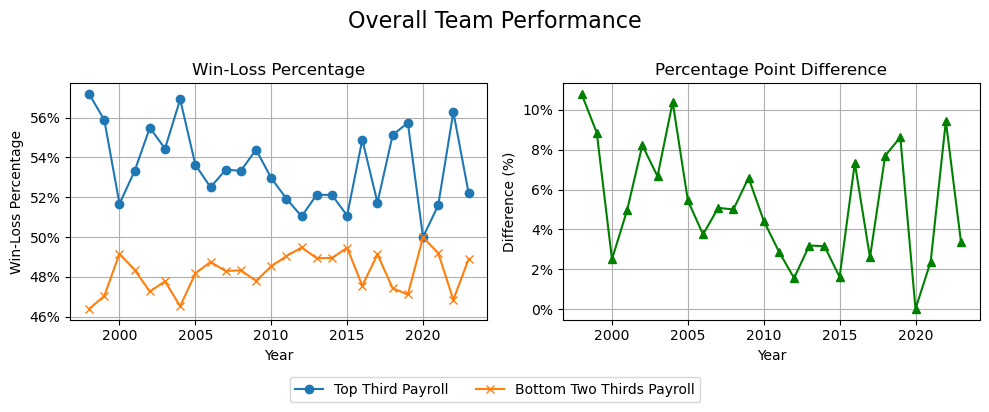

In [16]:
# Define a function to format the y-axis labels as percentages
def to_percentage(x, pos):
    return "%1.0f%%" % (100 * x)


# Create the formatter object
percentage_formatter = FuncFormatter(to_percentage)

# Adjust subplot configuration and figure size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.suptitle("Overall Team Performance", fontsize=16, y=0.95)

# Plot Win-Loss Percentage with y-axis as percentages
df = average_metrics_by_year["WL%_HITTING"]
axes[0].plot(df.index, df["top"], label="Top Third Payroll", marker="o")
axes[0].plot(
    df.index,
    df[["bottom", "middle"]].mean(axis=1),
    label="Bottom Two Thirds Payroll",
    marker="x",
)
axes[0].set_title("Win-Loss Percentage")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Win-Loss Percentage")
axes[0].grid(True)
axes[0].yaxis.set_major_formatter(percentage_formatter)

# Calculate and Plot the Difference as Percentage
difference = df["top"] - df[["bottom", "middle"]].mean(
    axis=1
)  # Calculate difference in percentage points
axes[1].plot(
    df.index,
    difference,
    label="Difference (Top - Bottom Two)",
    marker="^",
    color="green",
)
axes[1].set_title("Percentage Point Difference")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Difference (%)")
axes[1].grid(True)
axes[1].yaxis.set_major_formatter(percentage_formatter)

# Create a single legend for the figure outside the plot area
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Great! Now, let's focus on hitting metrics
We'll plot OPS, Runs, Home Runs, and RBIs. All of these metrics have a direct correlation with success, so teams that have a higher value for these metrics indicates that those teams have a higher chance of overall success. 

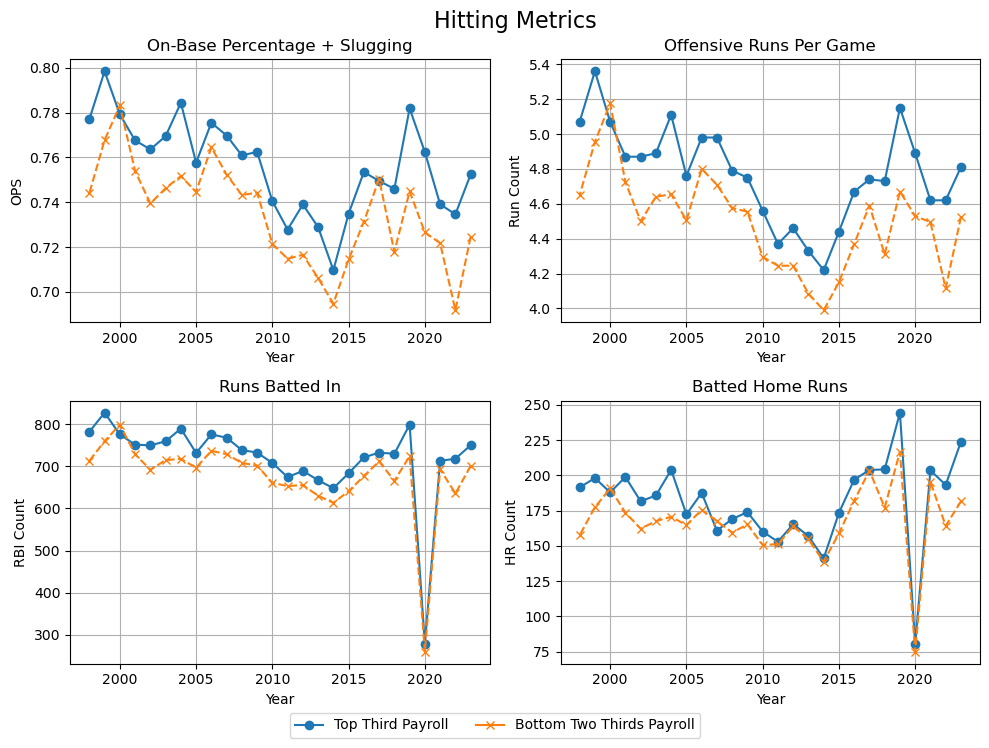

In [17]:
# Hitting Metrics: 2x2 subplot with customized titles and y-axis labels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.suptitle("Hitting Metrics", fontsize=16, y=0.92, x=0.52)

# Tuple format: (metric, plot title, y-axis label)
hitting_metrics_info = [
    ("OPS", "On-Base Percentage + Slugging", "OPS"),
    ("R/Gm", "Offensive Runs Per Game", "Run Count"),
    ("RBI", "Runs Batted In", "RBI Count"),
    ("HR_HITTING", "Batted Home Runs", "HR Count"),
]

for i, (metric, title, ylabel) in enumerate(hitting_metrics_info):
    ax = axes[i // 2, i % 2]
    df = average_metrics_by_year[metric]
    ax.plot(df.index, df["top"], label="Top Third Payroll", marker="o", linestyle="-")
    ax.plot(
        df.index,
        df[["bottom", "middle"]].mean(axis=1),
        label="Bottom Two Thirds Payroll",
        marker="x",
        linestyle="--",
    )
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    ax.grid(True)

fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Great! Now, let's focus on pitching metrics
We'll plot ERA, SO:BB, SO/9, and WHIP. ERA and WHIP are inversely related to success whereas SO:BB and SO/9 are directly correlated to success.

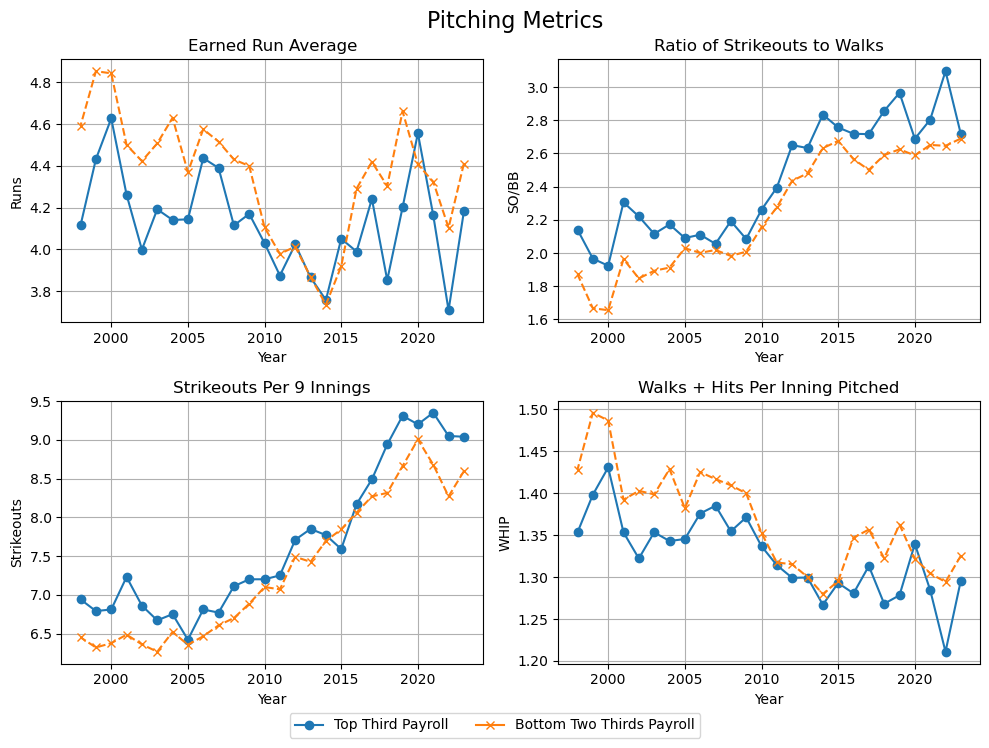

In [18]:
# Pitching Metrics: 2x2 subplot with customized titles and y-axis labels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.suptitle("Pitching Metrics", fontsize=16, y=0.92, x=0.52)

# Tuple format: (metric, plot title, y-axis label)
pitching_metrics_info = [
    ("ERA", "Earned Run Average", "Runs"),
    ("SO/BB", "Ratio of Strikeouts to Walks", "SO/BB"),
    ("SO9", "Strikeouts Per 9 Innings", "Strikeouts"),
    ("WHIP", "Walks + Hits Per Inning Pitched", "WHIP"),
]

for i, (metric, title, ylabel) in enumerate(pitching_metrics_info):
    ax = axes[i // 2, i % 2]
    df = average_metrics_by_year[metric]
    ax.plot(df.index, df["top"], label="Top Third Payroll", marker="o", linestyle="-")
    ax.plot(
        df.index,
        df[["bottom", "middle"]].mean(axis=1),
        label="Bottom Two Thirds Payroll",
        marker="x",
        linestyle="--",
    )
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    ax.grid(True)

fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### We see that for all metrics that we analyzed, teams with higher payrolls generally outperform teams with lower payrolls. 

In [19]:
%load_ext watermark
%watermark -v -m -p lets_plot,matplotlib,seaborn,requests,bs4,pandas,re

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.13.2

lets_plot : 4.2.0
matplotlib: 3.7.1
seaborn   : 0.12.2
requests  : 2.29.0
bs4       : 4.12.2
pandas    : 2.0.1
re        : 2.2.1

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.0-1050-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit



### **Thank you for reading!**